In [25]:
import numpy as np
import pandas as pd

In [26]:
# Columns we want from the dataset
columns_to_use = ['game_date', 'yardline_100', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'qb_dropback', 'qb_scramble', 'pass_length', 'pass_location', 'air_yards', 'yards_after_catch', 'run_location', 'run_gap', 'field_goal_result', 'kick_distance', 'extra_point_result', 'two_point_conv_result', 'incomplete_pass', 'interception', 'qb_hit', 'pass_attempt', 'rush_attempt', 'sack', 'touchdown', 'pass_touchdown', 'rush_touchdown', 'extra_point_attempt', 'two_point_attempt', 'field_goal_attempt', 'passer_player_id', 'passer_player_name', 'receiver_player_id', 'receiver_player_name', 'rusher_player_id', 'rusher_player_name']

### Fetched the following dataset from Kaggle:

https://www.kaggle.com/maxhorowitz/nflplaybyplay2009to2016?select=NFL+Play+by+Play+2009-2018+%28v5%29.csv

In [27]:
df = pd.read_csv("nfl_play_by_play.csv", usecols=columns_to_use)

/home/ec2-user/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (42) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [31]:
# Only want rows that correspond to the 4 specific play types
# And let's make sure we drop the old index
df = df[df['play_type'].isin(['pass', 'run', 'field_goal', 'extra_point'])].reset_index(drop=True)

In [32]:
def convertGameDateToSeason(game_date):
    # If the month is January or February, that means we are in the prior season. So year - 1
    # (game_date.month <= 2) will be 1 if prior season. 0 otherwise.
    return game_date.year - (game_date.month <= 2)

In [33]:
# Let's check the type of game date as we want to ensure it is a datetime object
df.dtypes['game_date']

dtype('O')

In [34]:
# Convert to a datetime object since it wasn't already
df['game_date'] = pd.to_datetime(df['game_date'])

In [35]:
# Let's double check
df.dtypes['game_date']

dtype('<M8[ns]')

In [36]:
# Create a new field to represent the season
df['season'] = df['game_date'].map(convertGameDateToSeason)

In [37]:
# Let's save all the plays by season for easy consumption later
for year in df['season'].unique():
    df[df['season'] == year].to_csv(f"season_datasets/{year}_plays.csv", index=False)

__Now that we have populated the files, let's read them and derive some extra columns we may want for our visualizations__


In [38]:
import numpy as np
import pandas as pd
import re

In [55]:
df['pass_location'].unique()

array(['left', nan, 'right', 'middle'], dtype=object)

__The pass location field doesn't provide the added level of granularity I want for my analysis so let's try parsing the description__

In [70]:
# Let's take a look at the pass plays that have no location
for description in df[(df['play_type'] == 'pass') & (df['pass_location'].isna())].sample(10).desc:
    print(description)

(15:00) (Shotgun) M.Cassel sacked at DAL 28 for -8 yards (C.Matthews).
(10:59) (Shotgun) A.Davis sacked at CLE 10 for -11 yards (L.Timmons). FUMBLES (L.Timmons), RECOVERED by PIT-A.Moats at CLE 8. A.Moats to CLE 8 for no gain (M.Schwartz).
(14:20) (Shotgun) E.Manning sacked at NYG 11 for -13 yards (T.Charlton).
(2:32) M.Hasselbeck sacked at SEA 25 for -9 yards (C.Haggans). FUMBLES (C.Haggans), RECOVERED by ARI-B.Robinson at SEA 23. B.Robinson to SEA 23 for no gain (M.Unger).
(12:55) C.Palmer pass incomplete to J.Nelson.
(5:38) (Shotgun) E.Manning sacked at GB 48 for -1 yards (A.Hawk).
(4:08) (Shotgun) A.Davis sacked at STL 15 for -7 yards (K.Martin). FUMBLES (K.Martin), RECOVERED by ARI-A.Cromartie at STL 14. A.Cromartie for 14 yards, TOUCHDOWN. The Replay Official challenged the fumble ruling, and the play was Upheld. The ruling on the field stands.
(12:06) (Shotgun) M.Mariota sacked at TEN 49 for -5 yards (M.Wilkerson). FUMBLES (M.Wilkerson), and recovers at TEN 41. M.Mariota to TEN 

__There are some that are passes with no location. But most of these look like sacks. So we can remove them from our analysis for now__

In [72]:
# Let's just check the number of each of the pass locations so we feel more comfortable filtering out.
print("Number of pass plays for each pass location")
print("="*50)
print("No Location: ", len(df[(df['play_type'] == 'pass') & (df['pass_location'].isna())]))
for location in ['left', 'right', 'middle']:
    print(f"{location}: ", len(df[(df['play_type'] == 'pass') & (df['pass_location'] == location)]))

Number of pass plays for each pass location
No Location:  12818
left:  62909
right:  70110
middle:  40840


In [73]:
# Let's see some sample description for each of the passing locations
for location in ['left', 'right', 'middle']:
    print("="*40, location, "="*40)
    for description in df[(df['play_type'] == 'pass') & (df['pass_location'] == location)].sample(5).desc:
        print(description)

======================================== left ========================================
(11:29) J.Campbell pass incomplete short left to J.Gordon (D.Milliner).
(7:30) C.Keenum pass short left to J.Cook to TB 35 for 15 yards (L.David).
(14:56) (Shotgun) T.Brady pass incomplete short left to D.Branch. Thrown wide of receiver along sideline at NE 43.
(2:17) (Shotgun) C.Henne pass incomplete short left to J.Shipley.
(10:03) (Shotgun) M.Ryan pass short left to R.White for 39 yards, TOUCHDOWN.
======================================== right ========================================
(11:05) M.Ryan pass incomplete deep right to R.White.
(:34) (Shotgun) B.Roethlisberger pass short right to L.Bell to CLE 13 for 5 yards (J.Taylor) [E.Ogbah].
(4:47) (Shotgun) M.Stafford pass short right to R.Bush to DET 32 for 10 yards (D.Davis; A.Allen).
(14:25) A.Smith pass short right to J.Maclin pushed ob at KC 45 for 7 yards (D.Amerson).
(11:35) (Shotgun) M.Cassel pass short right to J.Charles to WAS 44 for 2 ya

In [74]:
# Let's see if we can properly parse enough of the rows to get enough data for our analysis
df['pass_loc_detailed'] = df[df['play_type'] == 'pass']['desc'].str.extract(r"pass (?:incomplete )?([A-Za-z\s]+?)\.? (?:to|intended|intercepted)", flags=re.IGNORECASE)

In [82]:
# Let's see what we got!
df['pass_loc_detailed'].value_counts()

short right              56622
short left               50554
short middle             32976
deep right               12439
deep left                11969
deep middle               7699
incomplete                 103
right                       17
left                        16
middle                      12
short left end               3
short right end              2
was                          2
was thrown incomplete        1
Name: pass_loc_detailed, dtype: int64

__Since we want the extra granularity, let's just keep the first 6 listed above.__  
__Should be okay since the ones we are filtering out make up an extremely tiny porition of the data.__


In [90]:
# Let's just ensure that we can get the top 6 locations without having to hardcode based on the data
# We could also consider doing this by a percentage threshold but this is probably fine for now.
valid_locations = df['pass_loc_detailed'].value_counts().index[0:6]

In [91]:
valid_locations

Index(['short right', 'short left', 'short middle', 'deep right', 'deep left',
       'deep middle'],
      dtype='object')

In [114]:
df.loc[(df['play_type'] == 'pass') & ~(df['pass_loc_detailed'].isin(valid_locations)), 'pass_loc_detailed'] = np.nan

In [115]:
# Let's see what we got after we filtered out a bit
df['pass_loc_detailed'].value_counts()

short right     56622
short left      50554
short middle    32976
deep right      12439
deep left       11969
deep middle      7699
Name: pass_loc_detailed, dtype: int64

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

In [126]:
pass_locations_by_season = df[~df['pass_loc_detailed'].isna()].groupby(['season', 'pass_loc_detailed']).size().to_frame("num_plays")

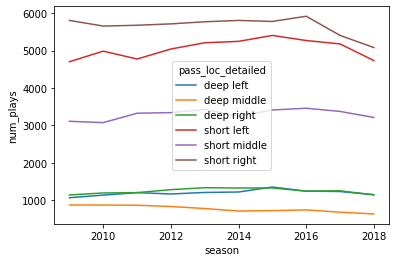

In [127]:
sns.lineplot(data=pass_locations_by_season.reset_index(), x='season', y='num_plays', hue='pass_loc_detailed');